**Biosppy exploration**
* filtering library for a variety of signals, [documentation](https://biosppy.readthedocs.io/en/stable/)
* ecg filtering is meant to be for a single lead only -- does that throw away a lot of useful information across 12 leads?
* also can extract very interesting features like filtered signal, r-preaks, templtes, heartbeat templates, heart rate reference, intstantaneous heart rate

**details of filtering**
* looks like the [ecg.ecg](https://github.com/PIA-Group/BioSPPy/blob/212c3dcbdb1ec43b70ba7199deb5eb22bcb78fd0/biosppy/signals/ecg.py) function applies, using [tools.filter_signal](https://github.com/PIA-Group/BioSPPy/blob/212c3dcbdb1ec43b70ba7199deb5eb22bcb78fd0/biosppy/signals/tools.py), by default (most of these are easily modifiable with alternative defaults)  
    * Finite Impulse Response filter ('FIR')
    * bandpass (low-pass, high-pass, band-pass, band-stop all available), 
    * order of the filter is adjustable and set to 0.3 * sampling rate 
    * between 3 and 45 HZ

**Plotting needs:**
* boxes are 1mm x 1mm, 0.04 sec x .1mV 
* horizontal scale is whatever length you want -- (looks like default is 60 boxes)
* vertical scale is 30 boxes, but they can run into each other


**Suggestions for the test we should run**
* filter all leads
* run through DL model
* see what changes in prediction

**Raw Data**
* rest_ecg
    * lots of fields in raw xml
    * extracted is just lead waveform
    * for each strip, following is true: sample_rate = 500 Hz, 5000 counts, units (uVperLsb) 5
    * for median strips, 600 counts, 500 hz, 5 uVper LSB, first last valid marks
    * Vector Loops?
    * Full disclosure data? 
    * Also have event time stamps
    * band pass filter
        * is it doing the right thing?
        * what will it cut out of afib?!?
* bike_ecg
    * strip (at the end? User instigated)
    * median
    * Full disclosure
    * Arrhythmia strips
    * FullDisclosure Start Time?
    * raw data fields in xmls (max heart rate, predicted max, actual max, target predicted, formala, percent,resting stats,  sthrs, ST time, maxst, units, stslope, phase information, trend data, units, st index, ST per chunk, strip data, cycle data, arrhythmia data, reason for termination
    * leads are I,2,3
    * start time, end time
    * same resolution, Hz = 500

In [1]:
from collections import defaultdict
import copy
import h5py
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from biosppy.signals import ecg
from biosppy.signals.tools import filter_signal

# IPython imports
from IPython.display import Image





/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


working on 2985417
		median_I
		median_II
		median_III
		median_V1
		median_V2
		median_V3
		median_V4
		median_V5
		median_V6
		median_aVF
		median_aVL
		median_aVR
		strip_I
		filtering strip_I


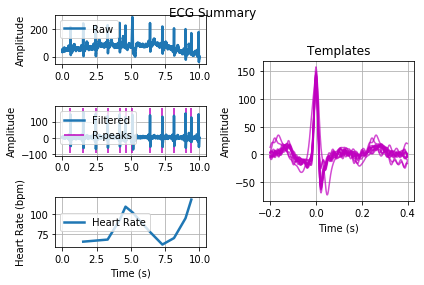

		strip_II
		filtering strip_II


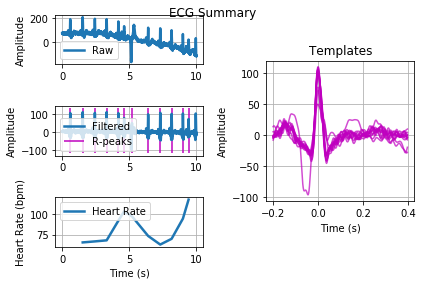

		strip_III
		filtering strip_III


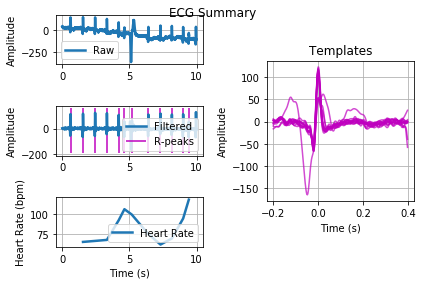

		strip_V1
		filtering strip_V1


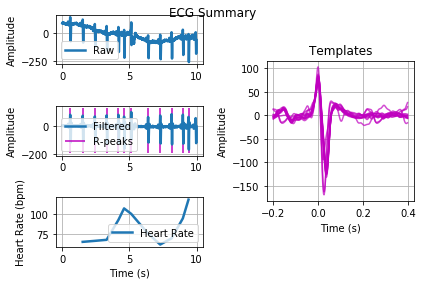

		strip_V2
		filtering strip_V2


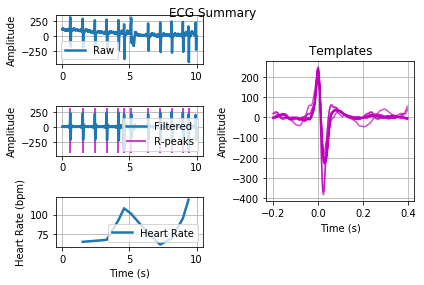

		strip_V3
		filtering strip_V3


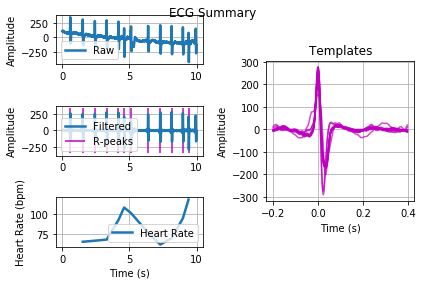

		strip_V4
		filtering strip_V4


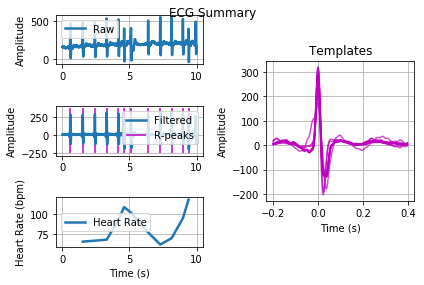

		strip_V5
		filtering strip_V5


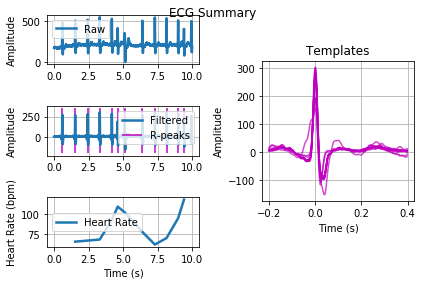

		strip_V6
		filtering strip_V6


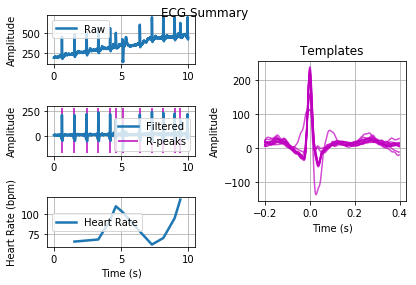

		strip_aVF
		filtering strip_aVF


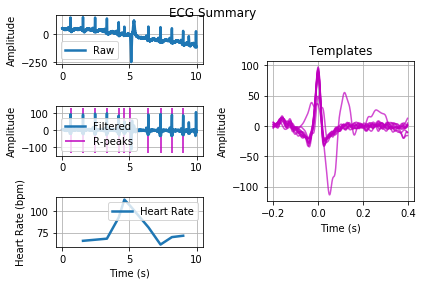

		strip_aVL
		filtering strip_aVL


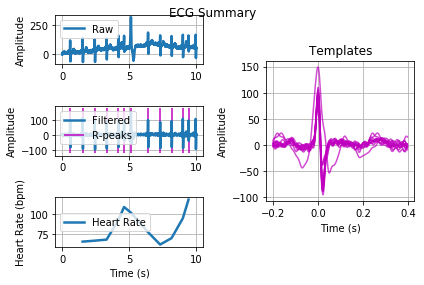

		strip_aVR
		filtering strip_aVR


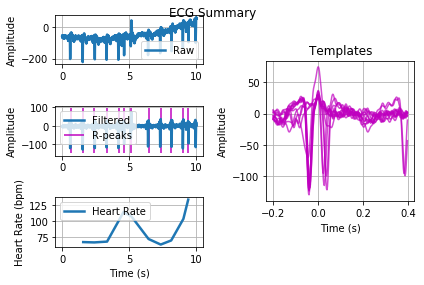

		 bike lead 0
		filtering bike lead 0


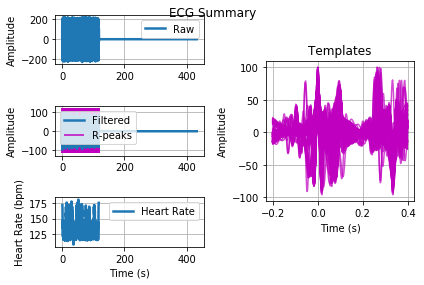

		 bike lead 1
		filtering bike lead 1


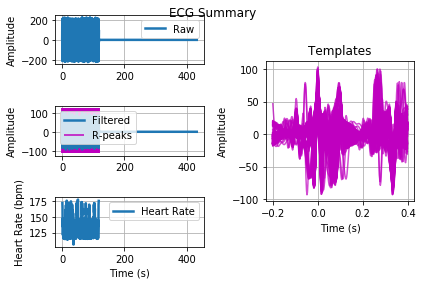

		 bike lead 2
		filtering bike lead 2


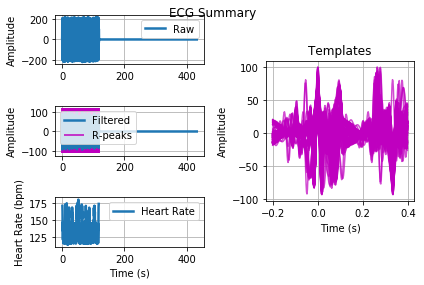

working on 5483286
		median_I
		median_II
		median_III
		median_V1
		median_V2
		median_V3
		median_V4
		median_V5
		median_V6
		median_aVF
		median_aVL
		median_aVR
		strip_I
		filtering strip_I


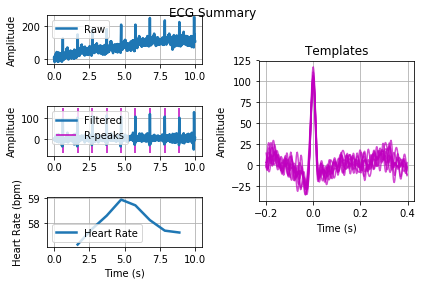

		strip_II
		filtering strip_II


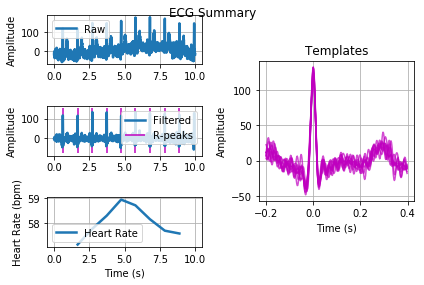

		strip_III
		filtering strip_III


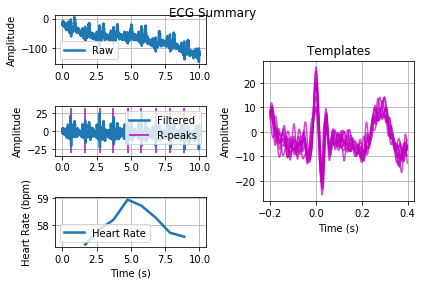

		strip_V1
		filtering strip_V1


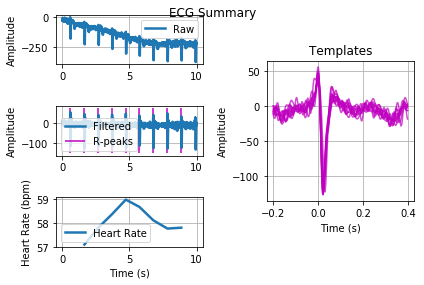

		strip_V2
		filtering strip_V2


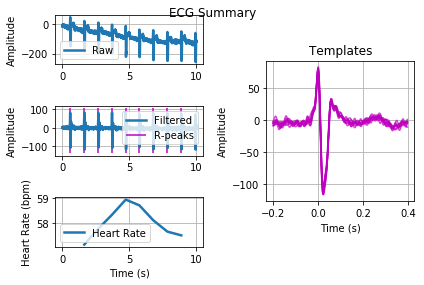

		strip_V3
		filtering strip_V3


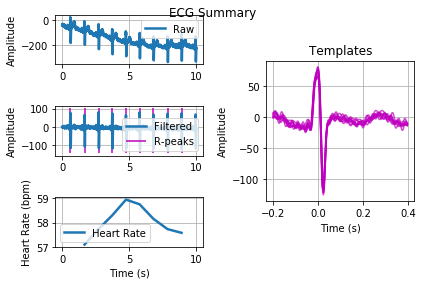

		strip_V4
		filtering strip_V4


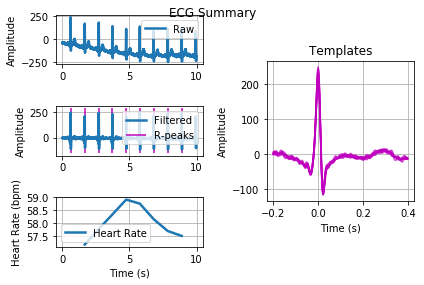

		strip_V5
		filtering strip_V5


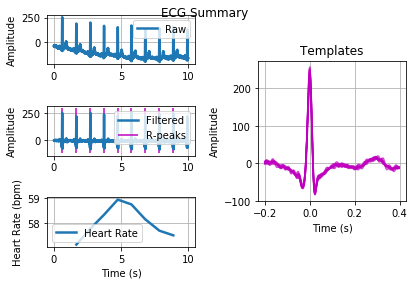

		strip_V6
		filtering strip_V6


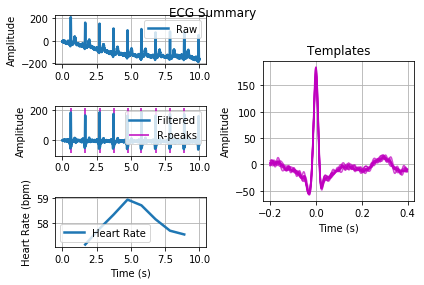

		strip_aVF
		filtering strip_aVF


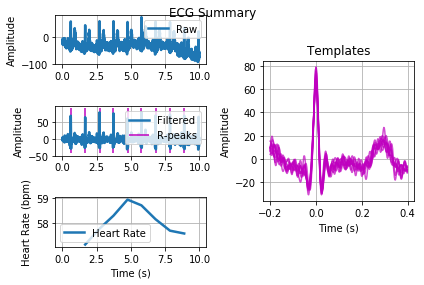

		strip_aVL
		filtering strip_aVL


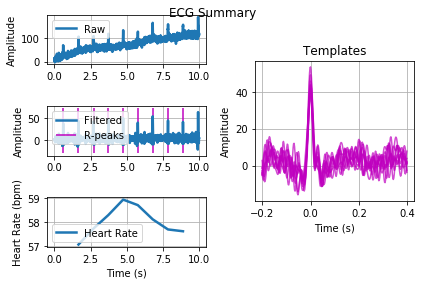

		strip_aVR
		filtering strip_aVR


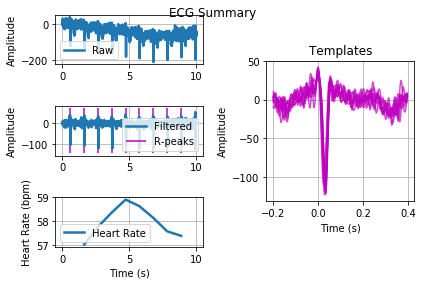

		 bike lead 0
		filtering bike lead 0


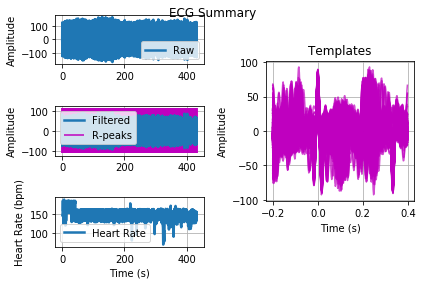

		 bike lead 1
		filtering bike lead 1


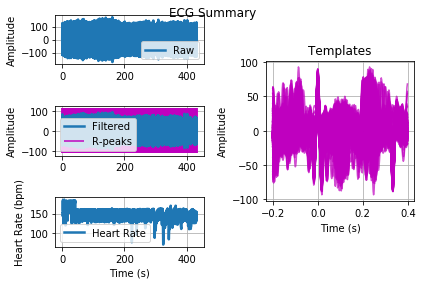

		 bike lead 2
		filtering bike lead 2


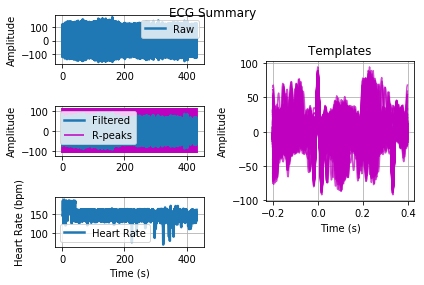

working on 1994810
		median_I
		median_II
		median_III
		median_V1
		median_V2
		median_V3
		median_V4
		median_V5
		median_V6
		median_aVF
		median_aVL
		median_aVR
		strip_I
		filtering strip_I


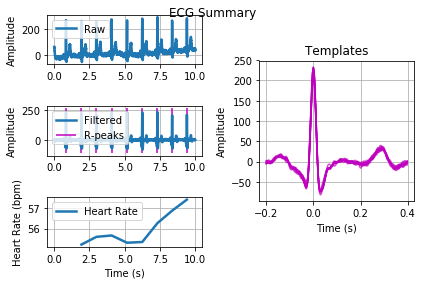

		strip_II
		filtering strip_II


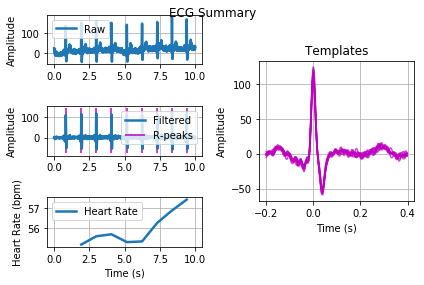

		strip_III
		filtering strip_III


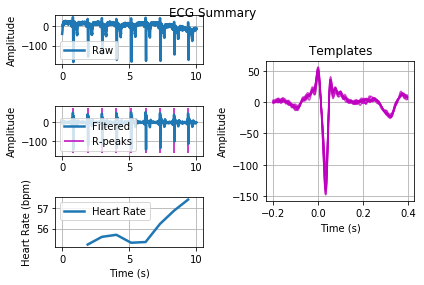

		strip_V1
		filtering strip_V1


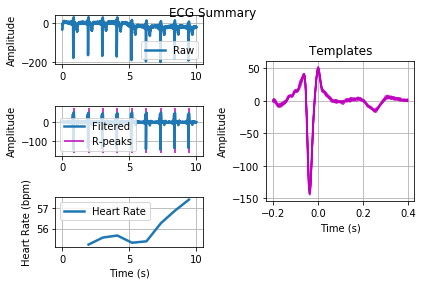

		strip_V2
		filtering strip_V2


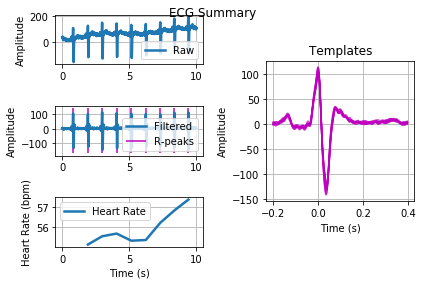

		strip_V3
		filtering strip_V3


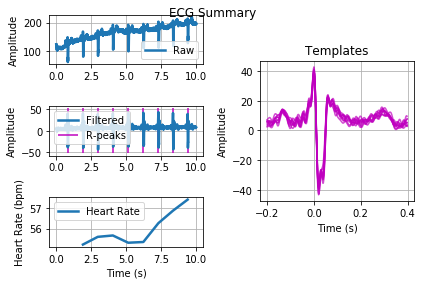

		strip_V4
		filtering strip_V4


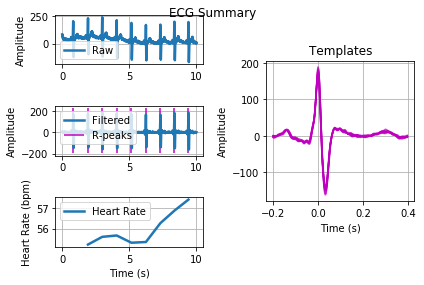

		strip_V5
		filtering strip_V5


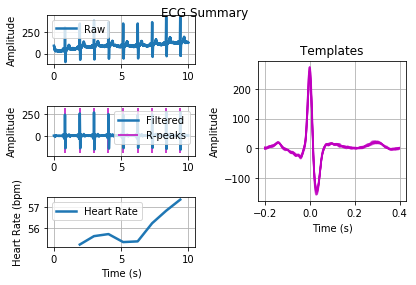

		strip_V6
		filtering strip_V6


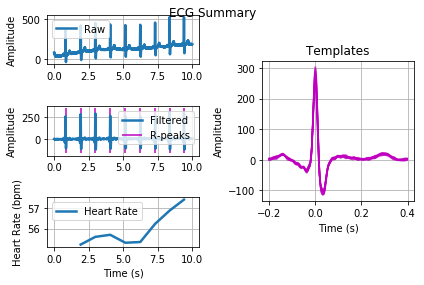

		strip_aVF
		filtering strip_aVF


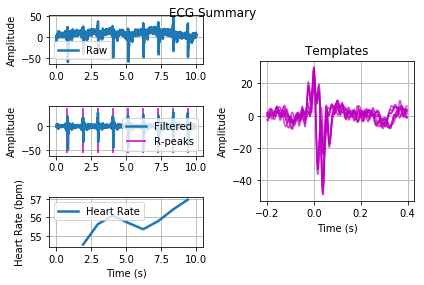

		strip_aVL
		filtering strip_aVL


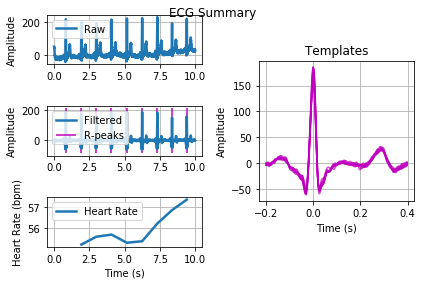

		strip_aVR
		filtering strip_aVR


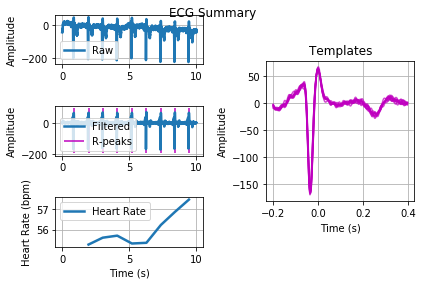

		 bike lead 0
		filtering bike lead 0


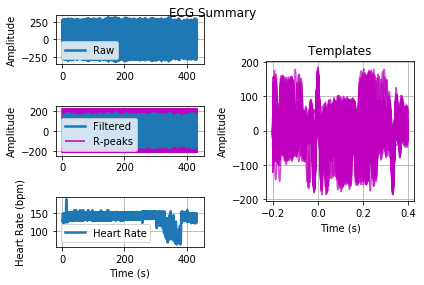

		 bike lead 1
		filtering bike lead 1


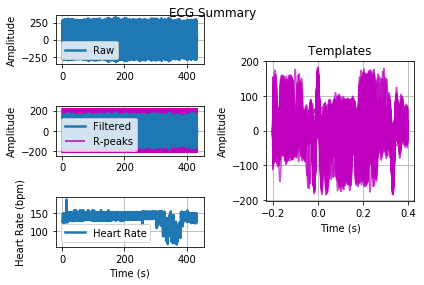

		 bike lead 2
		filtering bike lead 2


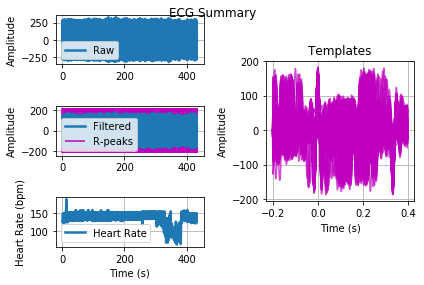

loaded 3 samples


In [6]:
#load all local samples
#DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/2019-04-26'
DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/ecg-rest-and-bike/2019-05-23/both'
#DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/ecg-rest-and-bike/2019-06-10/fast_test'
SAMPLE_LIMIT = 3
samples = {}

for sample_hd5 in os.listdir(DATA_DIRECTORY)[:SAMPLE_LIMIT]:
    print('working on %s' % sample_hd5[:-4])
    with h5py.File(os.path.join(DATA_DIRECTORY, sample_hd5)) as hd5:        
        ecg_rest = {}
        if 'ecg_rest' in hd5:
            '''loop over all ecg_rest fields, if they are the raw waveforms (not medians), 
               use biospy package to apply band-pass filter and store additional data'''
            for field in list(hd5['ecg_rest'].keys()):
                print(f'\t\t{field}')
                #keys include medians and raw
                data = {}
                data['raw'] = list(hd5['ecg_rest'][field]) #where are the ecg_Rest from separate instances?
                if len(data['raw']) == 5000: #if 5000 long, then raw
                    print(f'\t\tfiltering {field}')
                    sampling_rate = 500
                    (data['ts_reference'], data['filtered'], data['rpeaks'], 
                     data['template_ts'], data['templates'], data['heart_rate_ts'], 
                     data['heart_rate']) = ecg.ecg(signal=data['raw'], sampling_rate = sampling_rate)
                    #modifying band pass for experimentation
                    data['filtered_2'], _, _= filter_signal(signal=np.array(data['raw']),
                                          ftype='FIR',
                                          band='bandpass',
                                          order=int(0.3 * sampling_rate),
                                          frequency=[2, 10], #3,45
                                          sampling_rate=sampling_rate)
                ecg_rest[field]=data
        #repeat for ecg_bike
        #TODO: confirm that strip 0 vs strip 1 means instance, not the actualy lead strip, as in the rest_ecg.
        
        ecg_bike = {}
        if 'ecg_bike' in hd5 and 'full_0' in hd5['ecg_bike']:  
            for lead in range(0,3): #lead order is hard coded, believe order is ['I','2','3']
                data = {}
                print(f'\t\t bike lead {lead}')
                data['raw'] = hd5['ecg_bike']['full_0'][:,lead]  
                print(f'\t\tfiltering bike lead {lead}')
                sampling_rate = 500
                (data['ts_reference'], data['filtered'], data['rpeaks'], 
                 data['template_ts'], data['templates'], data['heart_rate_ts'], 
                 data['heart_rate']) = ecg.ecg(signal=data['raw'], sampling_rate = sampling_rate)
                #modifying band pass for experimentation
                data['filtered_2'], _, _= filter_signal(signal=np.array(data['raw']),
                                          ftype='FIR',
                                          band='bandpass',
                                          order=int(0.3 * sampling_rate),
                                          frequency=[2, 10], #3,45
                                          sampling_rate=sampling_rate)
                ecg_bike[lead]=data
    samples[sample_hd5[:-4]]={'ecg_rest': ecg_rest, 'ecg_bike': ecg_bike}
print('loaded %s samples' % len(samples) )

In [7]:
print(samples['2985417']['ecg_bike'].keys())

dict_keys([0, 1, 2])


/anaconda3/envs/ml4cvd/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


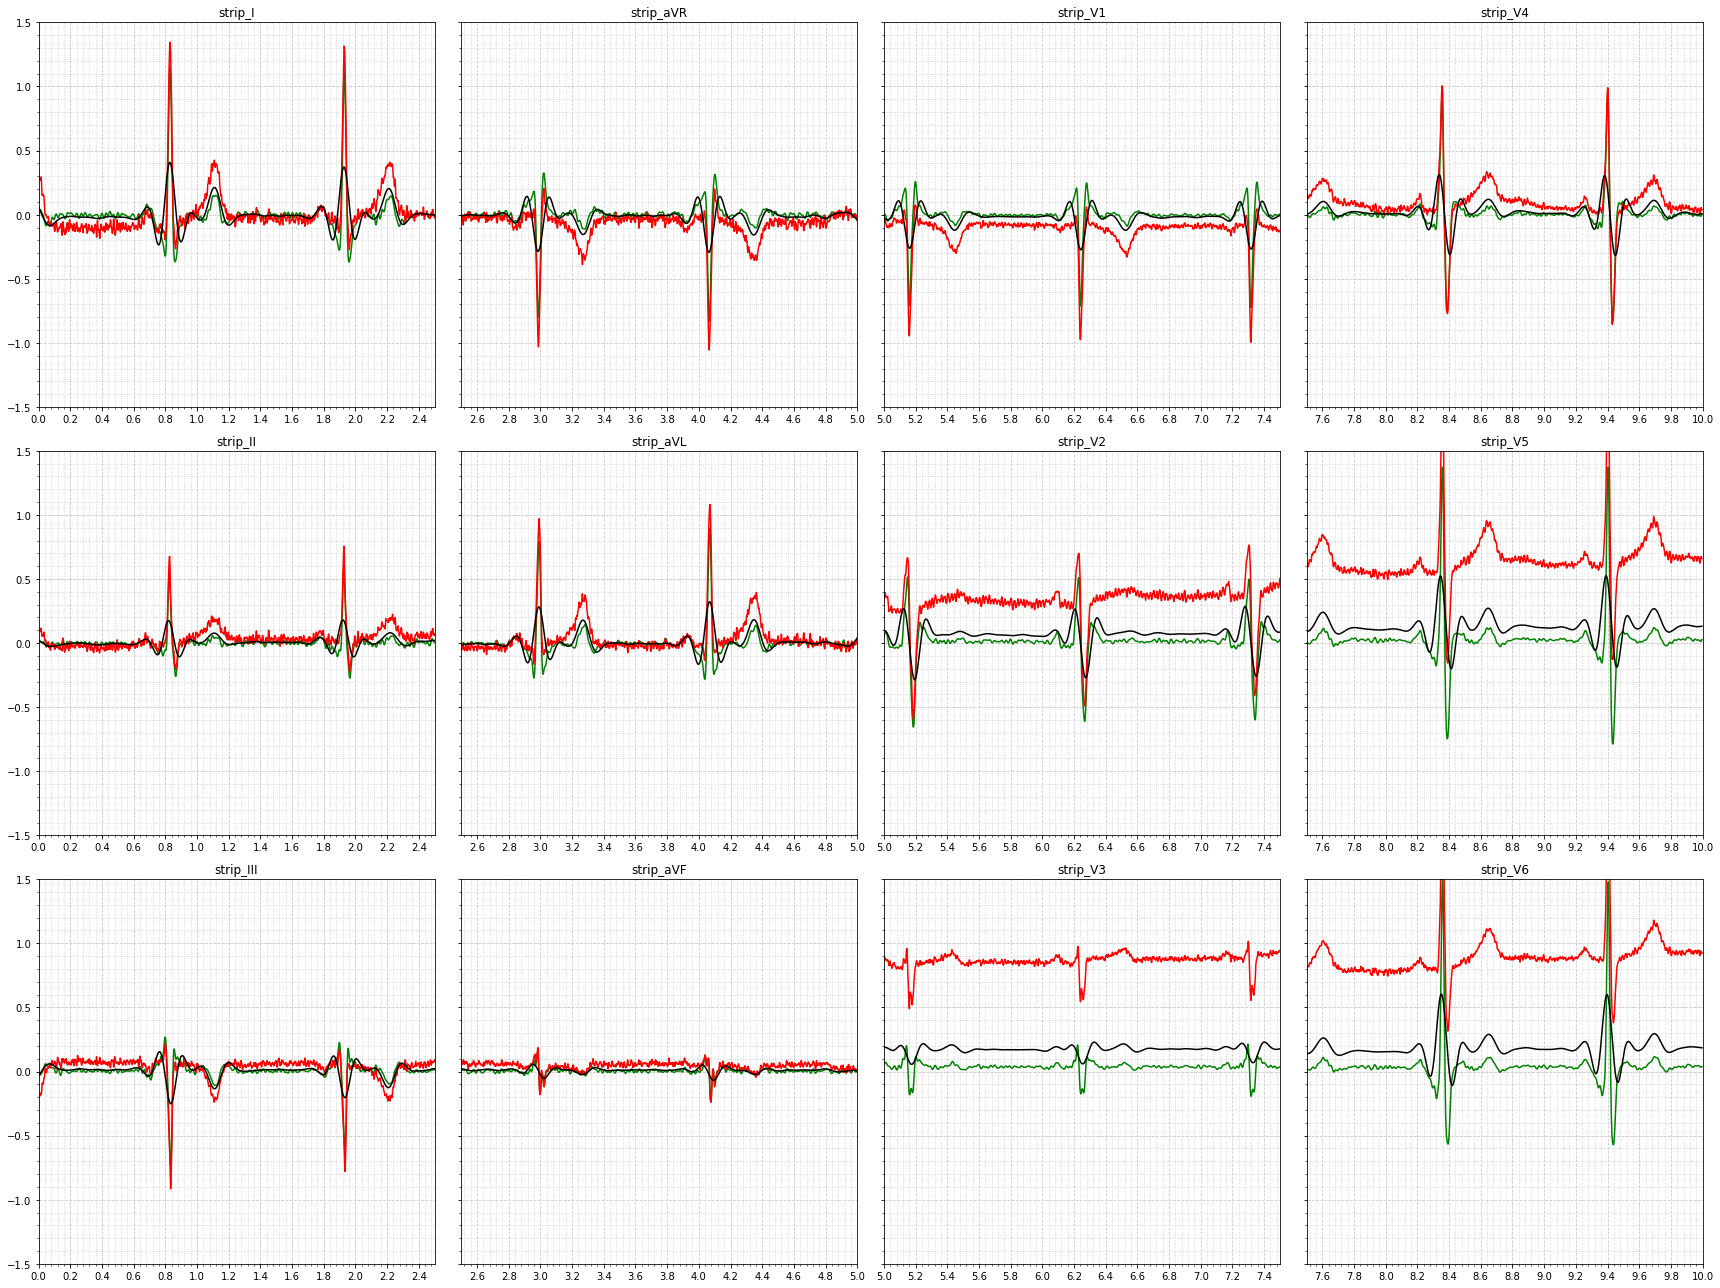

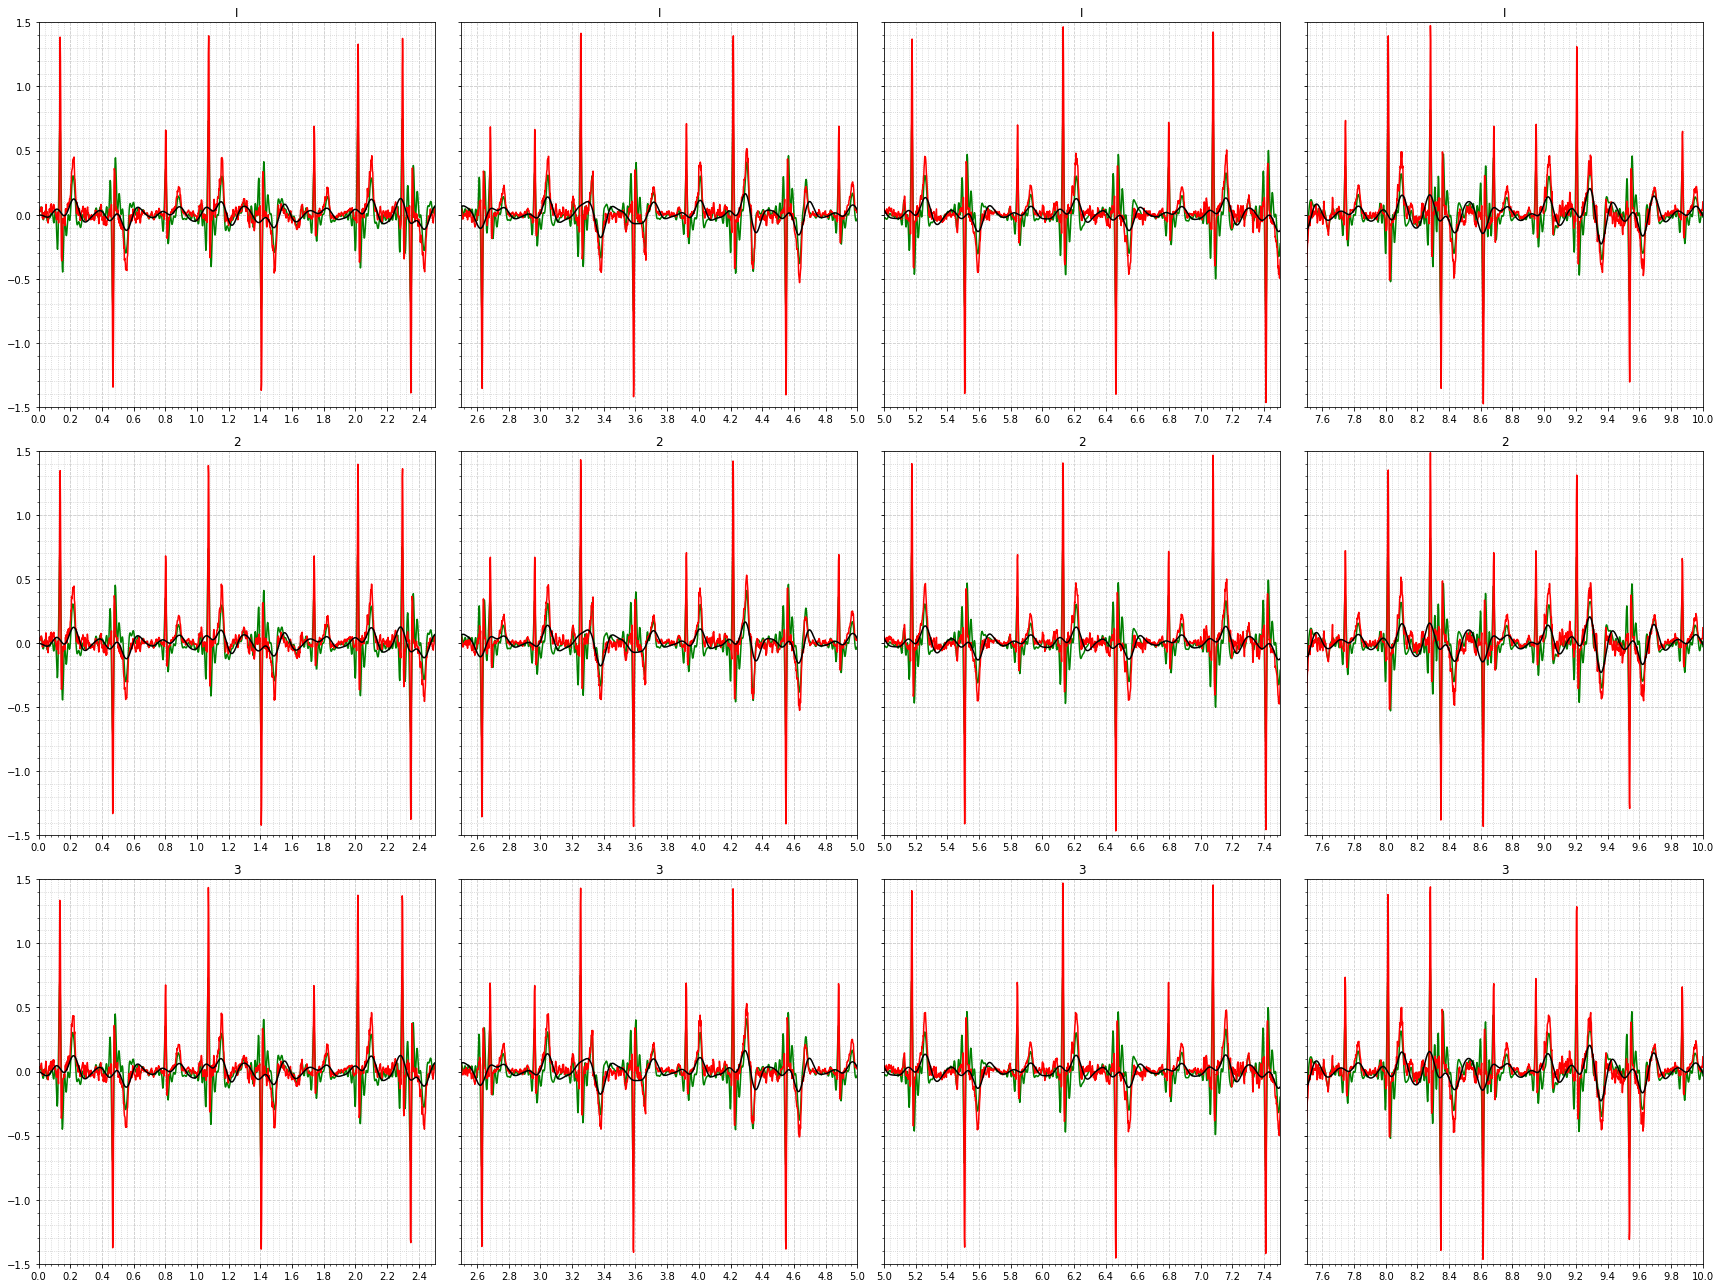

In [8]:
#file typically sent to steve
#file_id = '1000387'
#playing with bike/rest
file_id = '1994810'
test_data = samples[file_id]
#plt.plot()
#plot will be in seconds vs mV, boxes are 
sec_per_box = 0.04
mv_per_box = .1
time_interval = 2.5 #time-interval per plot in seconds. ts_Reference data is in s, voltage measurement is 5 uv per lsb
raw_scale = 0.005 # convert to mV
fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(24,18), tight_layout=True)

#REST ECG PLOTTING
lead_mapping=np.array([['strip_I','strip_aVR', 'strip_V1', 'strip_V4'],
              ['strip_II','strip_aVL', 'strip_V2', 'strip_V5'],
              ['strip_III','strip_aVF', 'strip_V3', 'strip_V6'],
             ])
for i in range(0,3):
    for j in range(0,4):
        lead_name = lead_mapping[i,j]
        lead = test_data['ecg_rest'][lead_name]
        ax[i,j].set_xlim(j*time_interval,(j+1)*time_interval)
        ax[i,j].set_ylim(-1.5, 1.5) #-1.5mV -> 1.5mV
        ax[i,j].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
        ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5))  #major grids at every .5mV 

        ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(5))
        ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(5))

        ax[i,j].grid(which='major', color='#CCCCCC', linestyle='--')
        ax[i,j].grid(which='minor', color='#CCCCCC', linestyle=':')
        
        #normalize data in muv
        ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered']], color='green')
        ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['raw']], color='red')
        ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered_2']], color = 'black')
        ax[i,j].set_title(lead_name)
#fig.savefig(f'{file_id}.pdf')
#BIKE ECG PLOTTING
lead_mapping=np.array([['strip_I','strip_aVR', 'strip_V1', 'strip_V4'],
              ['strip_II','strip_aVL', 'strip_V2', 'strip_V5'],
              ['strip_III','strip_aVF', 'strip_V3', 'strip_V6'],
             ])
fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(24,18), tight_layout=True)
lead_mapping=np.array([[0,0,0,0],
          [1,1,1,1],
          [2,2,2,2],
         ])
lead_names={0:'I', 1:'2', 2:'3'}
if 'ecg_bike' in test_data:
    ecg_bike = test_data['ecg_bike']
    for i in range(0,3):
        for j in range(0,4):
            lead_index = lead_mapping[i,j] 
            lead_name = lead_names[lead_index]
            lead = ecg_bike[lead_index] #hard mapping to row
            ax[i,j].set_xlim(j*time_interval,(j+1)*time_interval)
            ax[i,j].set_ylim(-1.5, 1.5) #-1.5mV -> 1.5mV
            ax[i,j].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
            ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5))  #major grids at every .5mV 

            ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(5))

            ax[i,j].grid(which='major', color='#CCCCCC', linestyle='--')
            ax[i,j].grid(which='minor', color='#CCCCCC', linestyle=':')

            #normalize data in muv
            ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered']], color='green')
            ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['raw']], color='red')
            ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered_2']], color = 'black')
            ax[i,j].set_title(lead_name)


To do:
* tensormaps?
* tensorgenerators?
* create models?
* think about performance comparison (structured, raw, extracted recovery metrics, filters added, filters added and rpeaks etc extracted, spherical mapping)
* don't forget about the exciting thing which is combined gwas
* look up long QT syndrome (arrhythmia notes? where?)
* build tree organizer of counts by variables against outputs

In [ ]:
import sys
import argparse

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import train_multimodal_multitask
from ml4cvd.models import make_multimodal_to_multilabel_model
from ml4cvd.tensor_generators import TensorGenerator

sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-text3/2019-04-26/', 
            '--input_tensors', 'ecg_rest', 
            '--output_tensors', 'ecg_rhythm', 'ecg_normal', 'p-axis', 'p-duration', 
                'p-offset', 'p-onset', 'pp-interval', 'pq-interval', 'q-offset', 'q-onset', 
                'qrs-num', 'qrs-duration', 'r-axis', 'ventricular-rate',
            '--batch_size', '32', 
            '--epochs', '1',  
            '--learning_rate', '0.0001',
            '--training_steps', '20',
            '--inspect_model',
            '--id', 'ecg_regresser']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)
model = make_multimodal_to_multilabel_model(args.model_file, args.model_layers, args.model_freeze,
                                                args.tensor_maps_in, args.tensor_maps_out, args.activation,
                                                args.dense_layers, args.dropout, args.mlp_concat, args.conv_layers,
                                                args.max_pools, args.res_layers, args.dense_blocks, args.block_size,
                                                args.conv_bn, args.conv_x, args.conv_y, args.conv_z, args.conv_dropout,
                                                args.conv_width, args.u_connect, args.pool_x, args.pool_y, args.pool_z, args.padding,
                                                args.learning_rate)
model = train_model_from_generators(model, generate_train, generate_valid, args.training_steps,
                                        args.validation_steps, args.batch_size, args.epochs, args.patience,
                                        args.output_folder, args.id, args.inspect_model, args.inspect_show_labels)

In [ ]:
generator = TensorGenerator(3, args.tensor_maps_in, args.tensor_maps_out, paths, None, True)

In [ ]:
DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/ecg-rest-and-bike/2019-05-23/both'
with h5py.File(os.path.join(DATA_DIRECTORY, '1994810.hd5')) as hd5:
    print('\n\nall fields\n\n')
    #for field in list(hd5.keys()):
    #    print(field)
    print('\n\nall ecg_bike fields\n\n')
    bike_leads={}
    for field in hd5['ecg_bike']['full_0'].keys():
        print(hd5['ecg_bike'][field].shape[0])
    if hd5['ecg_bike']['strip_0']:
        lead = {}
        for i in range(0,3):
            lead['raw']=hd5['ecg_bike']['strip_0'][:,i]
            bike_leads[i]=lead
    #for field in list(hd5['ecg_bike'].keys()):
    #    print(field)
    #    data[field] = hd5['ecg_bike'][field][:]
        #print(list(hd5['ecg_bike'][field]))


In [ ]:
bike_leads[0]['raw'].shape


In [ ]:
shape(data['full_0'])

In [ ]:
data['full_0'].shape

In [ ]:
data['median_0'].shape

In [ ]:
data['strip_0'].shape

In [ ]:
len(data['strip_0'][:,0])

In [ ]:
for i in range(0,3):
    print(i)

In [ ]:
if 'a' in ('c', 'b'):
    print('boo')

In [ ]:
a = {'b':{'dog':3}}


In [ ]:
if 'c' in a and 'l' in a['c']:
    print('foo')

In [ ]:
lead_order = 'I,2,3'

In [ ]:
lead_order.split(',')